# Clustering with Kmeans

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
data = pd.read_csv('/Volumes/GoogleDrive/My Drive/Job Applications/JustWatch_challenge/data_clean.csv')

In [3]:
data.head()

,project_id,type,campaign_country,cluster,survey_date,release_date,impressions,yes_answers,no_answers,gender,age_range,diff_survey_release,watching_rate_%
0,project_2,wi,AT,SBC,2020-10-10,2020-10-23,4855,13,3,FEMALE,18to24,13,76.470588
1,project_1,vc,ES,Cast,2020-08-18,2020-03-18,7224,4,8,FEMALE,25to34,-153,18.181818
2,project_4,wi,DE,GermanPostWarHistory,2020-07-15,2020-09-25,2216,13,10,MALE,18to24,72,41.935484
3,project_5,vc,FR,PrimeVideoFans,2020-04-29,2020-04-15,5957,7,32,MALE,18to24,-14,13.207547
4,project_4,vc,DE,Core,2020-10-13,2020-09-25,1462,14,10,MALE,O55,-18,42.424242


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054 entries, 0 to 3053
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   project_id           3054 non-null   object 
 1   type                 3054 non-null   object 
 2   campaign_country     3054 non-null   object 
 3   cluster              3054 non-null   object 
 4   survey_date          3054 non-null   object 
 5   release_date         3054 non-null   object 
 6   impressions          3054 non-null   int64  
 7   yes_answers          3054 non-null   int64  
 8   no_answers           3054 non-null   int64  
 9   gender               3054 non-null   object 
 10  age_range            3054 non-null   object 
 11  diff_survey_release  3054 non-null   int64  
 12  watching_rate_%      3054 non-null   float64
dtypes: float64(1), int64(4), object(8)
memory usage: 310.3+ KB


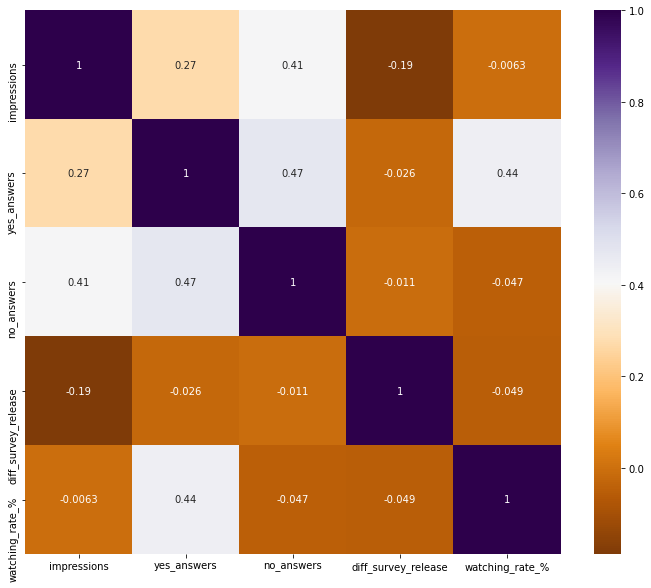

In [5]:
corr = data.corr()
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            annot=True,
            ax=ax,
            cmap='PuOr'
           )

### Drop the columns that I wont need for the model

In [7]:
data.drop(['survey_date', 'release_date'], axis=1, inplace=True)

In [8]:
data.head()

,project_id,type,campaign_country,cluster,impressions,yes_answers,no_answers,gender,age_range,diff_survey_release,watching_rate_%
0,project_2,wi,AT,SBC,4855,13,3,FEMALE,18to24,13,76.470588
1,project_1,vc,ES,Cast,7224,4,8,FEMALE,25to34,-153,18.181818
2,project_4,wi,DE,GermanPostWarHistory,2216,13,10,MALE,18to24,72,41.935484
3,project_5,vc,FR,PrimeVideoFans,5957,7,32,MALE,18to24,-14,13.207547
4,project_4,vc,DE,Core,1462,14,10,MALE,O55,-18,42.424242


In [ ]:
#data.to_csv(r'/Volumes/GoogleDrive/My Drive/Job Applications/JustWatch_challenge/data_for_models.csv', index = False)

# Preprocessing the data

In [9]:
categoricals = data.select_dtypes(np.object)
numericals = data.select_dtypes(np.number)


print("Dataframe of numerical columns: ")
print()

display(numericals)

print("Dataframe of categorical columns: ")
print()

display(categoricals)

Dataframe of numerical columns: 



,impressions,yes_answers,no_answers,diff_survey_release,watching_rate_%
0,4855,13,3,13,76.470588
1,7224,4,8,-153,18.181818
2,2216,13,10,72,41.935484
3,5957,7,32,-14,13.207547
4,1462,14,10,-18,42.424242
...,...,...,...,...,...
3049,2642,0,0,-7,0.000000
3050,20428,1,2,-111,10.000000
3051,2199,4,12,81,10.526316
3052,849,0,0,-7,0.000000


Dataframe of categorical columns: 



,project_id,type,campaign_country,cluster,gender,age_range
0,project_2,wi,AT,SBC,FEMALE,18to24
1,project_1,vc,ES,Cast,FEMALE,25to34
2,project_4,wi,DE,GermanPostWarHistory,MALE,18to24
3,project_5,vc,FR,PrimeVideoFans,MALE,18to24
4,project_4,vc,DE,Core,MALE,O55
...,...,...,...,...,...,...
3049,project_8,vc,GB,Mixed_Segment_B,MALE,35to44
3050,project_1,vc,DE,PrimeVideoFans,FEMALE,45to54
3051,project_14,wi,DE,GermanComedyStandUp,FEMALE,35to44
3052,project_8,vc,GB,Control,MALE,18to24


In [10]:
#Lets apply scaling to the numerical columns except the final column
#which will be our y variable, average gift

from sklearn.preprocessing import StandardScaler

transformer = StandardScaler().fit(numericals)
scaled_numericals = transformer.transform(numericals)

In [11]:
scaled_numericals

array([[-0.29646139,  0.14722359, -0.43648928,  0.18595221,  2.46721185],
       [-0.1165787 , -0.39485111, -0.29283672, -2.53212518, -0.14153933],
       [-0.4968457 ,  0.14722359, -0.2353757 ,  1.15201586,  0.92157117],
       ...,
       [-0.49813654, -0.39485111, -0.17791468,  1.29938151, -0.48416624],
       [-0.60064461, -0.6357732 , -0.52268081, -0.14152699, -0.95527824],
       [-0.21703662,  0.14722359, -0.43648928,  0.18595221,  2.10694974]])

In [12]:
pdscaled_numericals= pd.DataFrame(scaled_numericals,index=numericals.index.tolist(), columns=numericals.columns.tolist())

In [13]:
pdscaled_numericals.head()

,impressions,yes_answers,no_answers,diff_survey_release,watching_rate_%
0,-0.296461,0.147224,-0.436489,0.185952,2.467212
1,-0.116579,-0.394851,-0.292837,-2.532125,-0.141539
2,-0.496846,0.147224,-0.235376,1.152016,0.921571
3,-0.212784,-0.214160,0.396696,-0.256145,-0.364166
4,-0.554098,0.207454,-0.235376,-0.321641,0.943446


In [14]:
pdscaled_numericals.shape

(3054, 5)

## Dummifying categorical columns

In [15]:
cat_encoded = pd.get_dummies(categoricals, drop_first=True)
cat_encoded.head()

,project_id_project_10,project_id_project_11,project_id_project_12,project_id_project_13,project_id_project_14,project_id_project_2,project_id_project_3,project_id_project_4,project_id_project_5,project_id_project_6,...,cluster_ViewedFlockSpots,cluster_ViewedPrimeVideoCampaigns,cluster_VisuallyArresting,cluster_WomensFavouriteTV,cluster_YoungAdultsDrama,gender_MALE,age_range_25to34,age_range_35to44,age_range_45to54,age_range_O55
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1


In [16]:
cat_encoded.shape

(3054, 149)

## Putting everything together

In [17]:
full = pd.concat([pdscaled_numericals,cat_encoded],axis=1)
print("The dataset size is: ", full.shape)
print()
full

The dataset size is:  (3054, 154)



,impressions,yes_answers,no_answers,diff_survey_release,watching_rate_%,project_id_project_10,project_id_project_11,project_id_project_12,project_id_project_13,project_id_project_14,...,cluster_ViewedFlockSpots,cluster_ViewedPrimeVideoCampaigns,cluster_VisuallyArresting,cluster_WomensFavouriteTV,cluster_YoungAdultsDrama,gender_MALE,age_range_25to34,age_range_35to44,age_range_45to54,age_range_O55
0,-0.296461,0.147224,-0.436489,0.185952,2.467212,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.116579,-0.394851,-0.292837,-2.532125,-0.141539,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,-0.496846,0.147224,-0.235376,1.152016,0.921571,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,-0.212784,-0.214160,0.396696,-0.256145,-0.364166,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,-0.554098,0.207454,-0.235376,-0.321641,0.943446,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3049,-0.464499,-0.635773,-0.522681,-0.141527,-0.955278,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3050,0.886026,-0.575543,-0.465220,-1.844419,-0.507722,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3051,-0.498137,-0.394851,-0.177915,1.299382,-0.484166,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3052,-0.600645,-0.635773,-0.522681,-0.141527,-0.955278,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Building the model

In [18]:
#arbitrary choice ok n_cluster

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(full)

KMeans(n_clusters=4, random_state=42)

In [19]:
kmeans.inertia_

17949.337822686175

In [20]:
# Predicting / assigning the clusters
clusters = kmeans.predict(full)

In [21]:
# show the count of clusters 1, 2, 3 ... 8
pd.DataFrame(pd.Series(clusters).value_counts().sort_index(),
            columns=['count'],
            )

,count
0,1154
1,1021
2,198
3,681


## Tuning the model

### Finding the best number of k_cluster with the elbow method

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

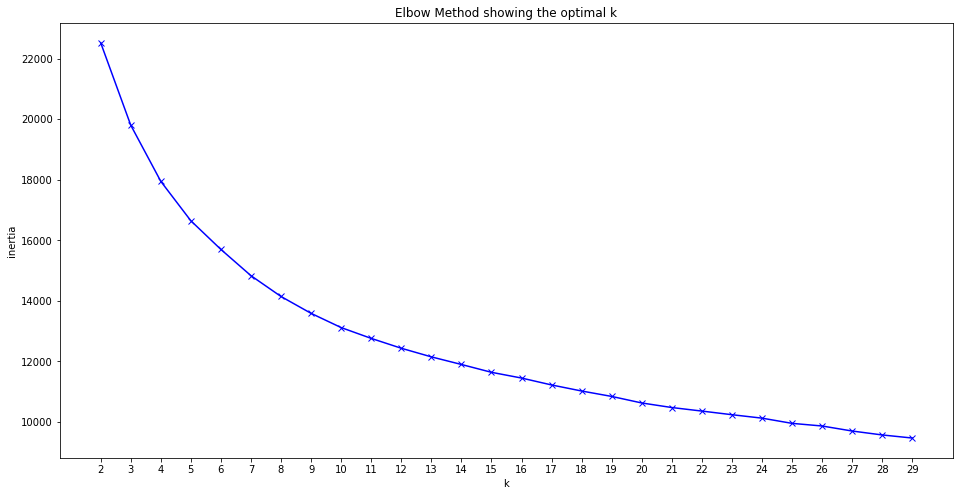

In [23]:
K = range(2, 30)
inertia = []

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k,
                    random_state=42)
    kmeans.fit(full)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

### refining the choice of clusters with the silhoutte score

[Silhoutte score](https://en.wikipedia.org/wiki/Silhouette_(clustering)): *How similar is an observation to its own cluster compared to other clusters?*
Score ranges from 1 to -1. High value: Object matches well to own cluster, low value correspondingly.

1. For each point p, first find the average distance between p and all other points in the same cluster (this is a measure of cohesion, call it A).

2. Then find the average distance between p and all points in the nearest cluster (this is a measure of separation from the closest other cluster, call it B).

3. The silhouette coefficient for p is defined as the difference between B and A divided by the greater of the two (max(A,B)).

4. We evaluate the cluster coefficient of each point and from this we can obtain the 'overall' average cluster coefficient.

Intuitively, we are trying to measure the space between clusters. If cluster cohesion is good (A is small) and cluster separation is good (B is large), the numerator will be large, etc. 

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

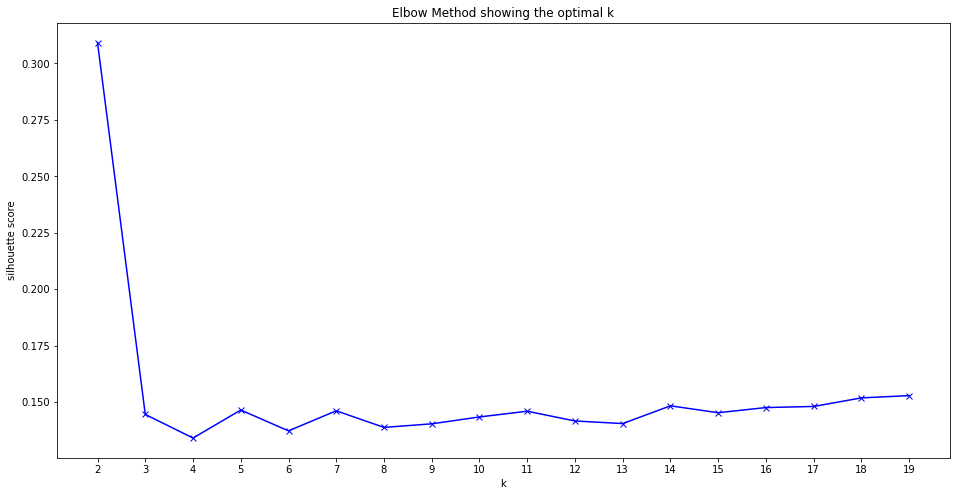

In [24]:
K = range(2, 20)
silhouette = []

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(full)
    silhouette.append(silhouette_score(full,
                                       kmeans.predict(full)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Text(0.5, 1.0, 'Elbow Method showing the optimal n_init')

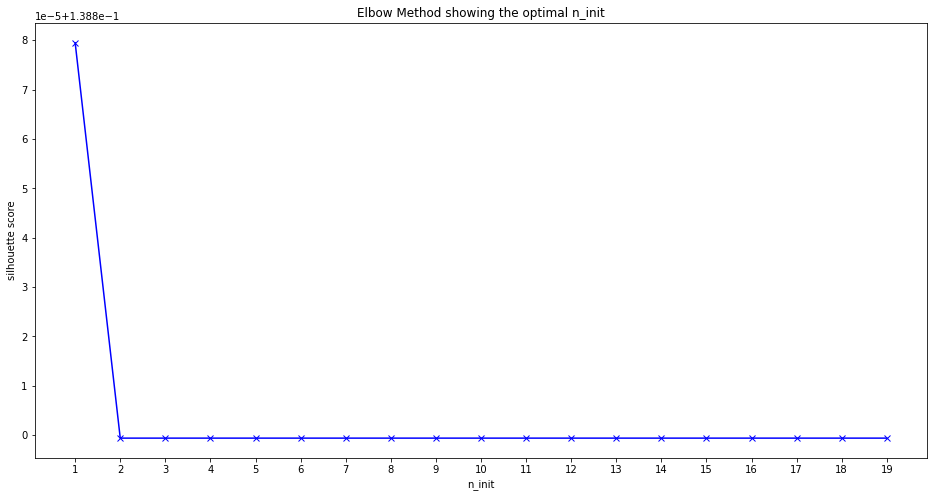

In [25]:
N_init = range(1, 20)
silhouette = []

for n in tqdm(N_init):
    kmeans = KMeans(n_clusters=8,
                    random_state=1234,
                   n_init=n)
    kmeans.fit(full)
    silhouette.append(silhouette_score(full,
                                       kmeans.predict(full)))


plt.figure(figsize=(16,8))
plt.plot(N_init, silhouette, 'bx-')
plt.xlabel('n_init')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(N_init), max(N_init)+1, 1.0))
plt.title('Elbow Method showing the optimal n_init')

### it looks like that from 8 clusters we have lecan be a good n_cluster

## Iteration with 8 clusters

In [26]:
kmeans = KMeans(n_clusters=8,init ='k-means++', n_init=10, max_iter=300, random_state=42)
kmeans.fit(full)

KMeans(random_state=42)

In [27]:
kmeans.inertia_

14146.325016085813

In [28]:
#inertia considerably decreased

In [29]:
# Predicting / assigning the clusters
clusters = kmeans.predict(full)

In [30]:
# show the count of clusters 
pd.DataFrame(pd.Series(clusters).value_counts().sort_index(),
            columns=['count'],
            )

,count
0,552
1,358
2,156
3,98
4,590
5,641
6,175
7,484


In [31]:
data['cluster_k_8']=clusters

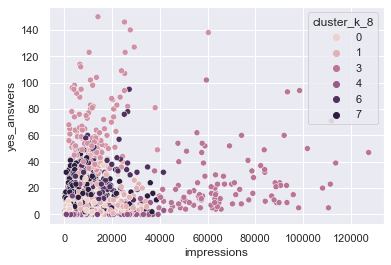

In [32]:
sns.set(font_scale=1)
sns.scatterplot(data=data, x="impressions", y="yes_answers", hue="cluster_k_8")

In [33]:
data_clusters= data.groupby(['cluster_k_8','cluster','age_range', 'gender', 'campaign_country'], as_index=False)['impressions', 'yes_answers'].sum()

<ipython-input-33-4a00639c3133>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_clusters= data.groupby(['cluster_k_8','cluster','age_range', 'gender', 'campaign_country'], as_index=False)['impressions', 'yes_answers'].sum()


In [34]:
display(data_clusters)

,cluster_k_8,cluster,age_range,gender,campaign_country,impressions,yes_answers
0,0,Action,18to24,FEMALE,DE,1294,1
1,0,Action,18to24,FEMALE,ES,15937,4
2,0,Action,18to24,FEMALE,FR,3825,5
3,0,Action,18to24,FEMALE,GB,3654,7
4,0,Action,18to24,MALE,DE,1464,0
...,...,...,...,...,...,...,...
2734,7,WomensFavouriteTV,18to24,MALE,GB,4871,11
2735,7,WomensFavouriteTV,45to54,FEMALE,GB,2806,3
2736,7,WomensFavouriteTV,45to54,MALE,DE,4067,2
2737,7,WomensFavouriteTV,O55,MALE,DE,6903,2


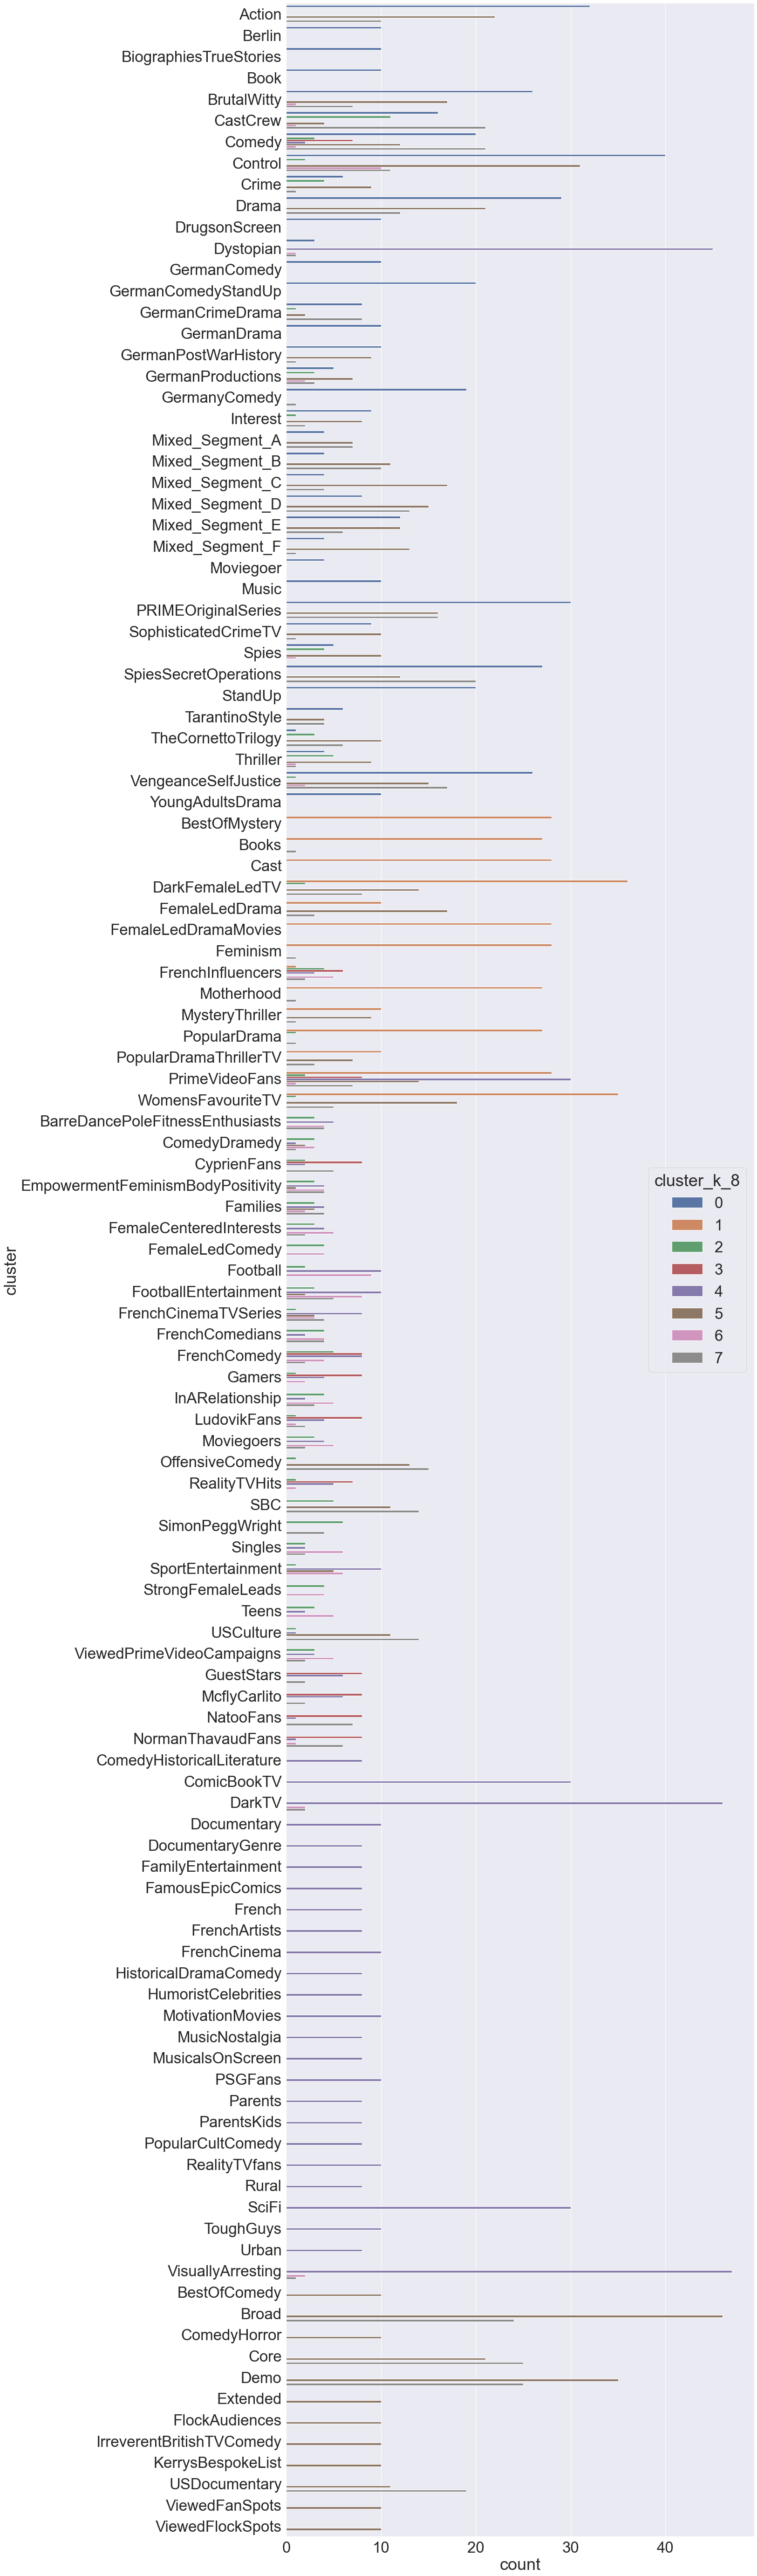

In [35]:
sns.set(font_scale=3)
fig_dims = (18, 100)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.countplot(y="cluster", hue="cluster_k_8", data=data_clusters)

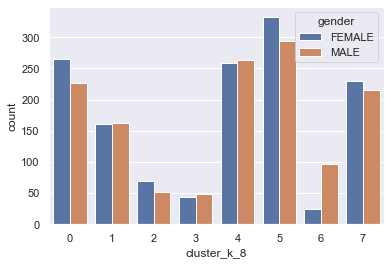

In [36]:
sns.set(font_scale=1)
g = sns.countplot(x="cluster_k_8", hue="gender", data=data_clusters)

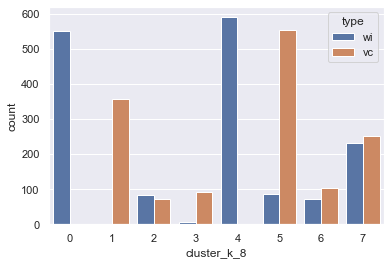

In [37]:
sns.set(font_scale=1)
g = sns.countplot(x="cluster_k_8", hue="type", data=data)

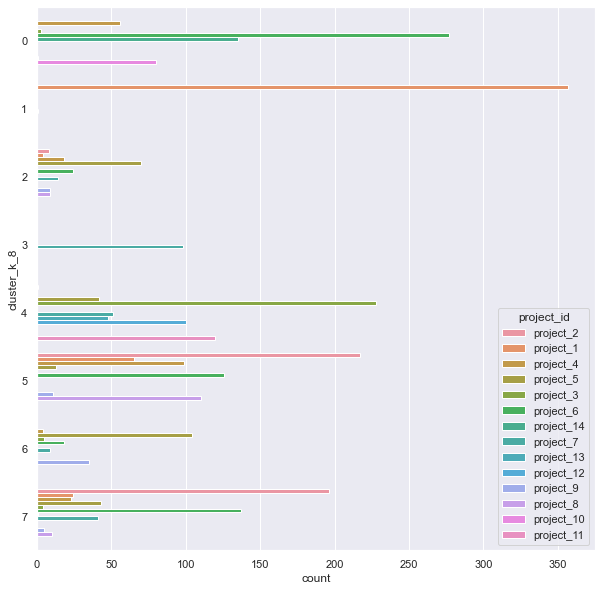

In [39]:
sns.set(font_scale=1)
fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)
g = sns.countplot(y="cluster_k_8", hue="project_id", data=data)

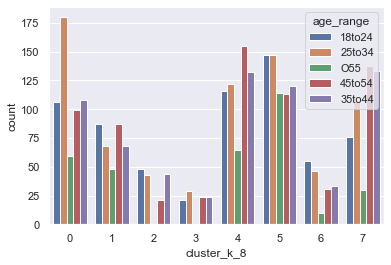

In [40]:
g = sns.countplot(x="cluster_k_8", hue="age_range", data=data)

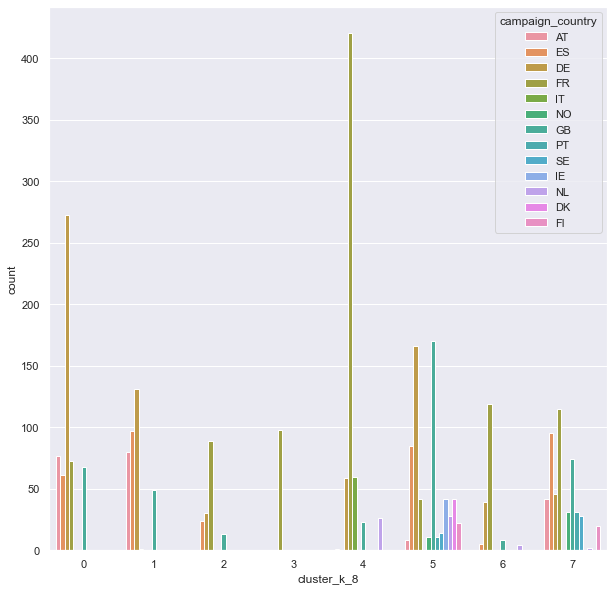

In [41]:
sns.set(font_scale=1)
fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.countplot(x="cluster_k_8", hue="campaign_country", data=data)

In [42]:
data.head()

,project_id,type,campaign_country,cluster,impressions,yes_answers,no_answers,gender,age_range,diff_survey_release,watching_rate_%,cluster_k_8
0,project_2,wi,AT,SBC,4855,13,3,FEMALE,18to24,13,76.470588,7
1,project_1,vc,ES,Cast,7224,4,8,FEMALE,25to34,-153,18.181818,1
2,project_4,wi,DE,GermanPostWarHistory,2216,13,10,MALE,18to24,72,41.935484,0
3,project_5,vc,FR,PrimeVideoFans,5957,7,32,MALE,18to24,-14,13.207547,5
4,project_4,vc,DE,Core,1462,14,10,MALE,O55,-18,42.424242,7


In [43]:
data.shape

(3054, 12)

In [44]:
data.to_csv(r'/Volumes/GoogleDrive/My Drive/Job Applications/JustWatch_challenge/data_8_clusters.csv', index = False)